In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 64)
        self.linear6 = nn.Linear(64, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 5000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {} | loss : {}".format(i_episode, t, total_reward,loss.item()))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/06 16:49:42
episode : 0 | final step : 99 | total reward : -19.800000000000004 | loss : -0.9366803765296936
2020/10/06 16:49:45
episode : 1 | final step : 98 | total reward : -6.4 | loss : 15.952903747558594
2020/10/06 16:49:49
episode : 2 | final step : 96 | total reward : 92.875 | loss : 14.93217658996582
2020/10/06 16:49:52
episode : 3 | final step : 98 | total reward : -10.600000000000001 | loss : 15.003259658813477
2020/10/06 16:49:55
episode : 4 | final step : 99 | total reward : -18.750000000000004 | loss : 14.611645698547363
2020/10/06 16:49:58
episode : 5 | final step : 98 | total reward : -19.400000000000002 | loss : 14.305913925170898
2020/10/06 16:50:01
episode : 6 | final step : 98 | total reward : -15.025000000000002 | loss : 15.71664047241211
2020/10/06 16:50:04
episode : 7 | final step : 99 | total reward : -22.450000000000006 | loss : 15.081306457519531
2020/10/06 16:50:07
episode : 8 | final step : 97 | total reward : 76.425 | loss : 14.733415603637695
2020/10

2020/10/06 16:54:08
episode : 77 | final step : 99 | total reward : -8.100000000000001 | loss : 18.212865829467773
2020/10/06 16:54:12
episode : 78 | final step : 100 | total reward : -44.025000000000006 | loss : 18.097034454345703
2020/10/06 16:54:15
episode : 79 | final step : 99 | total reward : 66.925 | loss : 18.13386344909668
2020/10/06 16:54:19
episode : 80 | final step : 98 | total reward : -26.450000000000003 | loss : 17.51880645751953
2020/10/06 16:54:22
episode : 81 | final step : 100 | total reward : 85.475 | loss : 17.979087829589844
2020/10/06 16:54:25
episode : 82 | final step : 96 | total reward : 58.425 | loss : 17.940174102783203
2020/10/06 16:54:28
episode : 83 | final step : 98 | total reward : -5.325 | loss : 17.350852966308594
2020/10/06 16:54:33
episode : 84 | final step : 99 | total reward : -27.775000000000002 | loss : 17.313648223876953
2020/10/06 16:54:36
episode : 85 | final step : 97 | total reward : 58.075 | loss : 17.407554626464844
2020/10/06 16:54:39
ep

2020/10/06 16:58:29
episode : 152 | final step : 99 | total reward : -46.925 | loss : 15.76638412475586
2020/10/06 16:58:33
episode : 153 | final step : 99 | total reward : -40.8 | loss : 15.230398178100586
2020/10/06 16:58:37
episode : 154 | final step : 100 | total reward : 26.17500000000001 | loss : 15.199026107788086
2020/10/06 16:58:40
episode : 155 | final step : 97 | total reward : 39.75 | loss : 16.13387680053711
2020/10/06 16:58:43
episode : 156 | final step : 99 | total reward : -63.57500000000001 | loss : 16.528072357177734
2020/10/06 16:58:47
episode : 157 | final step : 98 | total reward : 6.799999999999983 | loss : 16.202627182006836
2020/10/06 16:58:51
episode : 158 | final step : 98 | total reward : 16.575000000000017 | loss : 16.234527587890625
2020/10/06 16:58:53
episode : 159 | final step : 98 | total reward : 36.3 | loss : 16.50885772705078
2020/10/06 16:58:57
episode : 160 | final step : 96 | total reward : 37.3 | loss : 16.183204650878906
2020/10/06 16:59:01
episo

2020/10/06 17:02:51
episode : 226 | final step : 100 | total reward : 15.450000000000003 | loss : 15.548186302185059
2020/10/06 17:02:54
episode : 227 | final step : 100 | total reward : 17.300000000000026 | loss : 15.552617073059082
2020/10/06 17:02:58
episode : 228 | final step : 100 | total reward : -5.424999999999997 | loss : 15.335723876953125
2020/10/06 17:03:01
episode : 229 | final step : 95 | total reward : 25.275000000000006 | loss : 15.559076309204102
2020/10/06 17:03:04
episode : 230 | final step : 100 | total reward : 49.525000000000006 | loss : 15.55384635925293
2020/10/06 17:03:08
episode : 231 | final step : 99 | total reward : -20.89999999999999 | loss : 15.44204330444336
2020/10/06 17:03:12
episode : 232 | final step : 96 | total reward : 5.575000000000003 | loss : 15.27457046508789
2020/10/06 17:03:15
episode : 233 | final step : 100 | total reward : 11.775000000000006 | loss : 15.032674789428711
2020/10/06 17:03:18
episode : 234 | final step : 100 | total reward : 5

2020/10/06 17:07:08
episode : 299 | final step : 100 | total reward : 42.675000000000004 | loss : 15.184085845947266
2020/10/06 17:07:12
episode : 300 | final step : 95 | total reward : 46.4 | loss : 14.943512916564941
2020/10/06 17:07:15
episode : 301 | final step : 100 | total reward : 60.949999999999996 | loss : 15.059309959411621
2020/10/06 17:07:19
episode : 302 | final step : 98 | total reward : -36.6 | loss : 15.014700889587402
2020/10/06 17:07:22
episode : 303 | final step : 100 | total reward : -57.2 | loss : 14.490228652954102
2020/10/06 17:07:26
episode : 304 | final step : 98 | total reward : -34.85 | loss : 14.577226638793945
2020/10/06 17:07:30
episode : 305 | final step : 99 | total reward : 60.175 | loss : 14.811983108520508
2020/10/06 17:07:33
episode : 306 | final step : 96 | total reward : 64.625 | loss : 14.844127655029297
2020/10/06 17:07:36
episode : 307 | final step : 97 | total reward : 54.15 | loss : 15.13882064819336
2020/10/06 17:07:40
episode : 308 | final s

2020/10/06 17:11:32
episode : 374 | final step : 98 | total reward : 29.450000000000003 | loss : 14.650426864624023
2020/10/06 17:11:36
episode : 375 | final step : 99 | total reward : 47.074999999999996 | loss : 14.835514068603516
2020/10/06 17:11:40
episode : 376 | final step : 98 | total reward : -12.925 | loss : 14.638427734375
2020/10/06 17:11:43
episode : 377 | final step : 99 | total reward : -82.075 | loss : 13.677087783813477
2020/10/06 17:11:46
episode : 378 | final step : 95 | total reward : 9.124999999999986 | loss : 14.523728370666504
2020/10/06 17:11:51
episode : 379 | final step : 101 | total reward : 55.175 | loss : 14.544217109680176
2020/10/06 17:11:54
episode : 380 | final step : 98 | total reward : 58.15 | loss : 14.61445140838623
2020/10/06 17:11:57
episode : 381 | final step : 99 | total reward : -78.47500000000001 | loss : 14.400022506713867
2020/10/06 17:12:01
episode : 382 | final step : 98 | total reward : 35.52499999999999 | loss : 14.46915054321289
2020/10/0

2020/10/06 17:15:54
episode : 448 | final step : 99 | total reward : 50.125 | loss : 14.448230743408203
2020/10/06 17:15:57
episode : 449 | final step : 100 | total reward : -85.6 | loss : 14.41793155670166
2020/10/06 17:16:01
episode : 450 | final step : 99 | total reward : -40.45000000000001 | loss : 13.859075546264648
2020/10/06 17:16:05
episode : 451 | final step : 101 | total reward : 41.25000000000001 | loss : 14.420295715332031
2020/10/06 17:16:08
episode : 452 | final step : 98 | total reward : 45.675 | loss : 14.046402931213379
2020/10/06 17:16:12
episode : 453 | final step : 98 | total reward : 36.84999999999999 | loss : 14.43697452545166
2020/10/06 17:16:15
episode : 454 | final step : 97 | total reward : 42.275 | loss : 14.352352142333984
2020/10/06 17:16:18
episode : 455 | final step : 96 | total reward : 25.599999999999994 | loss : 13.929412841796875
2020/10/06 17:16:22
episode : 456 | final step : 98 | total reward : -48.22500000000001 | loss : 14.438417434692383
2020/10

2020/10/06 17:20:19
episode : 523 | final step : 98 | total reward : -66.10000000000001 | loss : 14.102337837219238
2020/10/06 17:20:23
episode : 524 | final step : 101 | total reward : -18.700000000000003 | loss : 14.001557350158691
2020/10/06 17:20:26
episode : 525 | final step : 99 | total reward : 52.974999999999994 | loss : 14.078390121459961
2020/10/06 17:20:30
episode : 526 | final step : 100 | total reward : -55.900000000000006 | loss : 14.121726989746094
2020/10/06 17:20:33
episode : 527 | final step : 98 | total reward : -49.800000000000004 | loss : 14.375518798828125
2020/10/06 17:20:37
episode : 528 | final step : 98 | total reward : -68.10000000000001 | loss : 14.128364562988281
2020/10/06 17:20:40
episode : 529 | final step : 99 | total reward : -4.650000000000006 | loss : 13.659102439880371
2020/10/06 17:20:44
episode : 530 | final step : 101 | total reward : -15.424999999999997 | loss : 13.947635650634766
2020/10/06 17:20:48
episode : 531 | final step : 98 | total rewar

2020/10/06 17:24:37
episode : 596 | final step : 99 | total reward : 26.400000000000006 | loss : 13.231273651123047
2020/10/06 17:24:41
episode : 597 | final step : 97 | total reward : 53.225 | loss : 13.711740493774414
2020/10/06 17:24:45
episode : 598 | final step : 99 | total reward : -52.275 | loss : 13.685847282409668
2020/10/06 17:24:48
episode : 599 | final step : 97 | total reward : -12.924999999999997 | loss : 13.705028533935547
2020/10/06 17:24:51
episode : 600 | final step : 98 | total reward : 26.60000000000001 | loss : 13.3751220703125
2020/10/06 17:24:55
episode : 601 | final step : 99 | total reward : 34.10000000000001 | loss : 13.670618057250977
2020/10/06 17:24:58
episode : 602 | final step : 98 | total reward : -57.82500000000001 | loss : 13.493875503540039
2020/10/06 17:25:02
episode : 603 | final step : 98 | total reward : -69.55000000000001 | loss : 13.287918090820312
2020/10/06 17:25:06
episode : 604 | final step : 100 | total reward : -0.5499999999999972 | loss :

2020/10/06 17:28:58
episode : 670 | final step : 99 | total reward : -9.424999999999997 | loss : 13.484136581420898
2020/10/06 17:29:02
episode : 671 | final step : 100 | total reward : 8.825000000000003 | loss : 13.455351829528809
2020/10/06 17:29:06
episode : 672 | final step : 100 | total reward : 22.97500000000001 | loss : 13.544919967651367
2020/10/06 17:29:09
episode : 673 | final step : 100 | total reward : 9.475000000000009 | loss : 13.161038398742676
2020/10/06 17:29:13
episode : 674 | final step : 98 | total reward : -50.199999999999996 | loss : 13.290523529052734
2020/10/06 17:29:17
episode : 675 | final step : 99 | total reward : 60.949999999999996 | loss : 13.111621856689453
2020/10/06 17:29:20
episode : 676 | final step : 100 | total reward : -12.175000000000011 | loss : 13.490089416503906
2020/10/06 17:29:24
episode : 677 | final step : 100 | total reward : 9.949999999999989 | loss : 13.585338592529297
2020/10/06 17:29:28
episode : 678 | final step : 99 | total reward : 

2020/10/06 17:33:15
episode : 743 | final step : 102 | total reward : 37.475 | loss : 13.056312561035156
2020/10/06 17:33:19
episode : 744 | final step : 98 | total reward : 19.07499999999999 | loss : 12.675274848937988
2020/10/06 17:33:22
episode : 745 | final step : 99 | total reward : -73.37499999999999 | loss : 12.922393798828125
2020/10/06 17:33:25
episode : 746 | final step : 98 | total reward : -62.5 | loss : 13.281259536743164
2020/10/06 17:33:29
episode : 747 | final step : 100 | total reward : 43.050000000000004 | loss : 12.6424560546875
2020/10/06 17:33:33
episode : 748 | final step : 98 | total reward : -9.900000000000006 | loss : 12.859521865844727
2020/10/06 17:33:36
episode : 749 | final step : 98 | total reward : -49.574999999999996 | loss : 12.894098281860352
2020/10/06 17:33:40
episode : 750 | final step : 96 | total reward : 27.775000000000006 | loss : 13.137813568115234
2020/10/06 17:33:44
episode : 751 | final step : 98 | total reward : -5.025000000000006 | loss : 

2020/10/06 17:37:36
episode : 817 | final step : 98 | total reward : -66.3 | loss : 12.333353996276855
2020/10/06 17:37:40
episode : 818 | final step : 99 | total reward : 65.0 | loss : 12.641223907470703
2020/10/06 17:37:43
episode : 819 | final step : 99 | total reward : -86.05 | loss : 12.371774673461914
2020/10/06 17:37:47
episode : 820 | final step : 98 | total reward : -77.975 | loss : 11.810564041137695
2020/10/06 17:37:50
episode : 821 | final step : 99 | total reward : -2.749999999999986 | loss : 13.198270797729492
2020/10/06 17:37:53
episode : 822 | final step : 98 | total reward : -69.15 | loss : 12.555662155151367
2020/10/06 17:37:57
episode : 823 | final step : 98 | total reward : -48.550000000000004 | loss : 11.81270980834961
2020/10/06 17:38:00
episode : 824 | final step : 96 | total reward : 35.675 | loss : 12.061811447143555
2020/10/06 17:38:03
episode : 825 | final step : 98 | total reward : -102.025 | loss : 12.737353324890137
2020/10/06 17:38:07
episode : 826 | fina

2020/10/06 17:42:02
episode : 892 | final step : 99 | total reward : -45.82500000000001 | loss : 12.251679420471191
2020/10/06 17:42:06
episode : 893 | final step : 102 | total reward : 46.99999999999999 | loss : 12.042235374450684
2020/10/06 17:42:10
episode : 894 | final step : 98 | total reward : -85.475 | loss : 11.524688720703125
2020/10/06 17:42:13
episode : 895 | final step : 98 | total reward : -5.049999999999997 | loss : 12.214152336120605
2020/10/06 17:42:17
episode : 896 | final step : 100 | total reward : 24.47500000000001 | loss : 12.167119979858398
2020/10/06 17:42:21
episode : 897 | final step : 98 | total reward : -99.85000000000001 | loss : 11.925424575805664
2020/10/06 17:42:24
episode : 898 | final step : 97 | total reward : -70.525 | loss : 12.117666244506836
2020/10/06 17:42:27
episode : 899 | final step : 98 | total reward : -64.675 | loss : 12.195562362670898
2020/10/06 17:42:29
episode : 900 | final step : 98 | total reward : 53.15 | loss : 11.853342056274414
20

2020/10/06 17:43:33
episode : 967 | final step : 98 | total reward : -46.49999999999999 | loss : 12.447040557861328
2020/10/06 17:43:34
episode : 968 | final step : 98 | total reward : -117.25 | loss : 12.223653793334961
2020/10/06 17:43:35
episode : 969 | final step : 98 | total reward : -118.85000000000001 | loss : 12.413809776306152
2020/10/06 17:43:36
episode : 970 | final step : 98 | total reward : -91.65 | loss : 12.192069053649902
2020/10/06 17:43:37
episode : 971 | final step : 99 | total reward : 0.625 | loss : 12.07868766784668
2020/10/06 17:43:38
episode : 972 | final step : 100 | total reward : -12.350000000000023 | loss : 11.826255798339844
2020/10/06 17:43:39
episode : 973 | final step : 98 | total reward : -80.925 | loss : 12.32697868347168
2020/10/06 17:43:40
episode : 974 | final step : 99 | total reward : -23.099999999999994 | loss : 12.535245895385742
2020/10/06 17:43:40
episode : 975 | final step : 100 | total reward : -15.149999999999991 | loss : 12.699771881103516

2020/10/06 17:44:44
episode : 1041 | final step : 99 | total reward : -66.94999999999999 | loss : 11.380951881408691
2020/10/06 17:44:45
episode : 1042 | final step : 99 | total reward : -43.12499999999999 | loss : 12.49251937866211
2020/10/06 17:44:46
episode : 1043 | final step : 100 | total reward : 9.549999999999997 | loss : 12.029167175292969
2020/10/06 17:44:47
episode : 1044 | final step : 98 | total reward : 37.375 | loss : 12.133421897888184
2020/10/06 17:44:48
episode : 1045 | final step : 98 | total reward : -37.175000000000004 | loss : 12.19778060913086
2020/10/06 17:44:49
episode : 1046 | final step : 99 | total reward : -53.550000000000004 | loss : 12.26713752746582
2020/10/06 17:44:50
episode : 1047 | final step : 98 | total reward : -49.225 | loss : 12.305733680725098
2020/10/06 17:44:51
episode : 1048 | final step : 98 | total reward : -108.125 | loss : 12.142194747924805
2020/10/06 17:44:52
episode : 1049 | final step : 98 | total reward : -111.875 | loss : 11.7959270

2020/10/06 17:45:53
episode : 1115 | final step : 99 | total reward : -61.95 | loss : 10.798440933227539
2020/10/06 17:45:54
episode : 1116 | final step : 98 | total reward : -68.075 | loss : 11.70012092590332
2020/10/06 17:45:55
episode : 1117 | final step : 96 | total reward : 47.12499999999999 | loss : 11.321739196777344
2020/10/06 17:45:56
episode : 1118 | final step : 98 | total reward : -31.075 | loss : 11.058640480041504
2020/10/06 17:45:57
episode : 1119 | final step : 98 | total reward : -40.800000000000004 | loss : 11.75925350189209
2020/10/06 17:45:58
episode : 1120 | final step : 98 | total reward : -101.2 | loss : 10.537518501281738
2020/10/06 17:45:59
episode : 1121 | final step : 100 | total reward : 21.849999999999994 | loss : 11.714424133300781
2020/10/06 17:46:00
episode : 1122 | final step : 98 | total reward : -83.67500000000001 | loss : 12.153553009033203
2020/10/06 17:46:01
episode : 1123 | final step : 99 | total reward : -78.825 | loss : 11.698771476745605
2020/

2020/10/06 17:47:04
episode : 1190 | final step : 98 | total reward : -117.0 | loss : 10.89069938659668
2020/10/06 17:47:05
episode : 1191 | final step : 99 | total reward : -103.4 | loss : 11.213752746582031
2020/10/06 17:47:05
episode : 1192 | final step : 98 | total reward : -112.625 | loss : 10.774517059326172
2020/10/06 17:47:06
episode : 1193 | final step : 103 | total reward : -22.474999999999994 | loss : 9.912410736083984
2020/10/06 17:47:07
episode : 1194 | final step : 97 | total reward : 54.975 | loss : 11.830831527709961
2020/10/06 17:47:08
episode : 1195 | final step : 100 | total reward : -96.37499999999999 | loss : 10.83139705657959
2020/10/06 17:47:09
episode : 1196 | final step : 98 | total reward : -104.22500000000001 | loss : 10.300838470458984
2020/10/06 17:47:10
episode : 1197 | final step : 100 | total reward : -115.49999999999999 | loss : 11.460718154907227
2020/10/06 17:47:11
episode : 1198 | final step : 100 | total reward : -20.375 | loss : 11.755081176757812


2020/10/06 17:48:13
episode : 1264 | final step : 99 | total reward : -100.425 | loss : 10.323497772216797
2020/10/06 17:48:14
episode : 1265 | final step : 98 | total reward : -71.5 | loss : 9.940624237060547
2020/10/06 17:48:15
episode : 1266 | final step : 99 | total reward : -78.77499999999999 | loss : 10.873013496398926
2020/10/06 17:48:15
episode : 1267 | final step : 98 | total reward : -116.15 | loss : 10.748950958251953
2020/10/06 17:48:16
episode : 1268 | final step : 99 | total reward : -89.075 | loss : 9.015206336975098
2020/10/06 17:48:17
episode : 1269 | final step : 98 | total reward : -11.100000000000009 | loss : 10.051517486572266
2020/10/06 17:48:18
episode : 1270 | final step : 99 | total reward : -2.5999999999999943 | loss : 10.147878646850586
2020/10/06 17:48:19
episode : 1271 | final step : 98 | total reward : -78.125 | loss : 10.579021453857422
2020/10/06 17:48:20
episode : 1272 | final step : 98 | total reward : -93.77499999999999 | loss : 10.205224990844727
202

2020/10/06 17:49:20
episode : 1338 | final step : 99 | total reward : -69.825 | loss : 8.958368301391602
2020/10/06 17:49:21
episode : 1339 | final step : 98 | total reward : -88.425 | loss : 8.81831169128418
2020/10/06 17:49:22
episode : 1340 | final step : 100 | total reward : -26.150000000000006 | loss : 10.279549598693848
2020/10/06 17:49:23
episode : 1341 | final step : 98 | total reward : -115.725 | loss : 9.998234748840332
2020/10/06 17:49:24
episode : 1342 | final step : 98 | total reward : -97.0 | loss : 9.788008689880371
2020/10/06 17:49:25
episode : 1343 | final step : 99 | total reward : -73.55 | loss : 10.210959434509277
2020/10/06 17:49:26
episode : 1344 | final step : 98 | total reward : -89.57499999999999 | loss : 10.150373458862305
2020/10/06 17:49:27
episode : 1345 | final step : 98 | total reward : -112.57500000000002 | loss : 10.390876770019531
2020/10/06 17:49:28
episode : 1346 | final step : 99 | total reward : -14.399999999999991 | loss : 9.975805282592773
2020/1

2020/10/06 17:50:28
episode : 1412 | final step : 95 | total reward : 8.950000000000003 | loss : 9.536638259887695
2020/10/06 17:50:29
episode : 1413 | final step : 98 | total reward : -98.60000000000001 | loss : 9.820375442504883
2020/10/06 17:50:30
episode : 1414 | final step : 98 | total reward : -85.8 | loss : 9.780799865722656
2020/10/06 17:50:31
episode : 1415 | final step : 100 | total reward : 4.525000000000006 | loss : 7.976120948791504
2020/10/06 17:50:32
episode : 1416 | final step : 98 | total reward : -80.65 | loss : 9.311368942260742
2020/10/06 17:50:33
episode : 1417 | final step : 98 | total reward : -82.65 | loss : 10.020049095153809
2020/10/06 17:50:34
episode : 1418 | final step : 98 | total reward : -107.525 | loss : 8.279932022094727
2020/10/06 17:50:34
episode : 1419 | final step : 98 | total reward : -87.02499999999999 | loss : 8.081493377685547
2020/10/06 17:50:35
episode : 1420 | final step : 98 | total reward : -86.425 | loss : 8.587507247924805
2020/10/06 17:

2020/10/06 17:51:37
episode : 1487 | final step : 99 | total reward : 2.25 | loss : 8.70111083984375
2020/10/06 17:51:37
episode : 1488 | final step : 99 | total reward : -105.77499999999999 | loss : 7.560638427734375
2020/10/06 17:51:38
episode : 1489 | final step : 98 | total reward : -83.97500000000001 | loss : 8.959850311279297
2020/10/06 17:51:39
episode : 1490 | final step : 98 | total reward : -109.175 | loss : 8.861566543579102
2020/10/06 17:51:40
episode : 1491 | final step : 99 | total reward : 9.674999999999997 | loss : 8.72900390625
2020/10/06 17:51:41
episode : 1492 | final step : 98 | total reward : -100.35000000000001 | loss : 9.020767211914062
2020/10/06 17:51:42
episode : 1493 | final step : 98 | total reward : -71.02500000000002 | loss : 8.638772010803223
2020/10/06 17:51:43
episode : 1494 | final step : 99 | total reward : -91.7 | loss : 9.018671989440918
2020/10/06 17:51:44
episode : 1495 | final step : 98 | total reward : -76.05000000000001 | loss : 7.4707407951354

2020/10/06 17:52:44
episode : 1562 | final step : 98 | total reward : -103.625 | loss : 7.255902290344238
2020/10/06 17:52:45
episode : 1563 | final step : 98 | total reward : -84.22500000000001 | loss : 8.875500679016113
2020/10/06 17:52:46
episode : 1564 | final step : 99 | total reward : -21.44999999999999 | loss : 7.770869731903076
2020/10/06 17:52:47
episode : 1565 | final step : 100 | total reward : -101.75 | loss : 7.6853837966918945
2020/10/06 17:52:48
episode : 1566 | final step : 98 | total reward : -101.05 | loss : 8.281890869140625
2020/10/06 17:52:49
episode : 1567 | final step : 98 | total reward : -103.65 | loss : 7.457913875579834
2020/10/06 17:52:50
episode : 1568 | final step : 98 | total reward : -106.65 | loss : 6.214478492736816
2020/10/06 17:52:51
episode : 1569 | final step : 98 | total reward : -110.14999999999999 | loss : 7.788116455078125
2020/10/06 17:52:52
episode : 1570 | final step : 99 | total reward : -108.15 | loss : 7.664882659912109
2020/10/06 17:52:5

2020/10/06 17:53:52
episode : 1636 | final step : 98 | total reward : -112.95 | loss : 7.342784881591797
2020/10/06 17:53:53
episode : 1637 | final step : 98 | total reward : -102.525 | loss : 7.629397869110107
2020/10/06 17:53:54
episode : 1638 | final step : 98 | total reward : -112.95 | loss : 7.831764221191406
2020/10/06 17:53:55
episode : 1639 | final step : 97 | total reward : -109.55 | loss : 7.5072479248046875
2020/10/06 17:53:56
episode : 1640 | final step : 99 | total reward : -102.19999999999999 | loss : 6.297996997833252
2020/10/06 17:53:57
episode : 1641 | final step : 98 | total reward : -114.275 | loss : 8.065372467041016
2020/10/06 17:53:58
episode : 1642 | final step : 98 | total reward : -118.375 | loss : 6.570326328277588
2020/10/06 17:53:59
episode : 1643 | final step : 97 | total reward : 4.349999999999994 | loss : 6.773159980773926
2020/10/06 17:54:00
episode : 1644 | final step : 98 | total reward : -110.02499999999999 | loss : 7.456690788269043
2020/10/06 17:54:

2020/10/06 17:55:05
episode : 1712 | final step : 98 | total reward : -114.35000000000001 | loss : 5.984747886657715
2020/10/06 17:55:06
episode : 1713 | final step : 98 | total reward : -116.22500000000001 | loss : 7.460543632507324
2020/10/06 17:55:07
episode : 1714 | final step : 102 | total reward : -15.425000000000011 | loss : 6.181557655334473
2020/10/06 17:55:07
episode : 1715 | final step : 99 | total reward : -19.799999999999997 | loss : 7.178157806396484
2020/10/06 17:55:08
episode : 1716 | final step : 99 | total reward : -114.35 | loss : 6.982779502868652
2020/10/06 17:55:09
episode : 1717 | final step : 98 | total reward : -108.2 | loss : 6.7316365242004395
2020/10/06 17:55:10
episode : 1718 | final step : 98 | total reward : -114.30000000000001 | loss : 5.802618503570557
2020/10/06 17:55:11
episode : 1719 | final step : 100 | total reward : -25.200000000000003 | loss : 6.901459693908691
2020/10/06 17:55:12
episode : 1720 | final step : 98 | total reward : -103.42500000000

2020/10/06 17:56:13
episode : 1786 | final step : 99 | total reward : -18.25 | loss : 6.098367691040039
2020/10/06 17:56:14
episode : 1787 | final step : 98 | total reward : -110.35000000000001 | loss : 7.389728546142578
2020/10/06 17:56:15
episode : 1788 | final step : 99 | total reward : -117.65 | loss : 5.762658596038818
2020/10/06 17:56:15
episode : 1789 | final step : 98 | total reward : -108.375 | loss : 6.197633743286133
2020/10/06 17:56:16
episode : 1790 | final step : 98 | total reward : -109.14999999999999 | loss : 6.612026214599609
2020/10/06 17:56:17
episode : 1791 | final step : 99 | total reward : -123.15 | loss : 5.754730224609375
2020/10/06 17:56:18
episode : 1792 | final step : 98 | total reward : -116.525 | loss : 5.7134785652160645
2020/10/06 17:56:19
episode : 1793 | final step : 98 | total reward : -121.275 | loss : 7.088554859161377
2020/10/06 17:56:20
episode : 1794 | final step : 97 | total reward : -15.474999999999994 | loss : 5.588081359863281
2020/10/06 17:56

2020/10/06 17:57:21
episode : 1861 | final step : 99 | total reward : -91.32499999999999 | loss : 6.001142501831055
2020/10/06 17:57:22
episode : 1862 | final step : 98 | total reward : -92.80000000000001 | loss : 6.922863006591797
2020/10/06 17:57:23
episode : 1863 | final step : 98 | total reward : -107.49999999999999 | loss : 5.830303192138672
2020/10/06 17:57:24
episode : 1864 | final step : 96 | total reward : 36.425000000000004 | loss : 7.361480712890625
2020/10/06 17:57:25
episode : 1865 | final step : 98 | total reward : -91.67500000000001 | loss : 5.7712273597717285
2020/10/06 17:57:25
episode : 1866 | final step : 98 | total reward : -82.77499999999999 | loss : 6.001561164855957
2020/10/06 17:57:26
episode : 1867 | final step : 99 | total reward : -66.64999999999999 | loss : 6.072629928588867
2020/10/06 17:57:27
episode : 1868 | final step : 98 | total reward : -103.22500000000001 | loss : 5.86442232131958
2020/10/06 17:57:28
episode : 1869 | final step : 99 | total reward : 

2020/10/06 17:58:28
episode : 1935 | final step : 99 | total reward : -100.65 | loss : 5.995217800140381
2020/10/06 17:58:29
episode : 1936 | final step : 96 | total reward : -9.525000000000006 | loss : 5.431099891662598
2020/10/06 17:58:30
episode : 1937 | final step : 98 | total reward : -101.95 | loss : 6.350625038146973
2020/10/06 17:58:31
episode : 1938 | final step : 98 | total reward : -70.675 | loss : 6.30172872543335
2020/10/06 17:58:32
episode : 1939 | final step : 98 | total reward : -105.825 | loss : 6.412878036499023
2020/10/06 17:58:33
episode : 1940 | final step : 98 | total reward : -96.22500000000001 | loss : 5.926090717315674
2020/10/06 17:58:33
episode : 1941 | final step : 99 | total reward : -118.24999999999999 | loss : 6.317009925842285
2020/10/06 17:58:34
episode : 1942 | final step : 99 | total reward : -59.775000000000006 | loss : 6.569394111633301
2020/10/06 17:58:35
episode : 1943 | final step : 99 | total reward : -66.375 | loss : 5.609636306762695
2020/10/0

2020/10/06 17:59:36
episode : 2009 | final step : 100 | total reward : -91.25 | loss : 5.782646179199219
2020/10/06 17:59:37
episode : 2010 | final step : 99 | total reward : -100.47500000000001 | loss : 6.364626884460449
2020/10/06 17:59:38
episode : 2011 | final step : 98 | total reward : -98.875 | loss : 5.829659461975098
2020/10/06 17:59:39
episode : 2012 | final step : 99 | total reward : -91.42499999999998 | loss : 5.819244384765625
2020/10/06 17:59:40
episode : 2013 | final step : 98 | total reward : -97.825 | loss : 5.338249206542969
2020/10/06 17:59:41
episode : 2014 | final step : 99 | total reward : -83.77499999999998 | loss : 5.815449237823486
2020/10/06 17:59:42
episode : 2015 | final step : 100 | total reward : 3.7250000000000227 | loss : 6.094973564147949
2020/10/06 17:59:43
episode : 2016 | final step : 99 | total reward : -81.2 | loss : 5.851914405822754
2020/10/06 17:59:44
episode : 2017 | final step : 98 | total reward : -59.97500000000001 | loss : 5.914494514465332


2020/10/06 18:00:47
episode : 2083 | final step : 98 | total reward : -74.7 | loss : 5.90120267868042
2020/10/06 18:00:47
episode : 2084 | final step : 99 | total reward : 16.075000000000003 | loss : 5.77091646194458
2020/10/06 18:00:48
episode : 2085 | final step : 98 | total reward : -66.85000000000001 | loss : 5.4260382652282715
2020/10/06 18:00:49
episode : 2086 | final step : 99 | total reward : 13.599999999999994 | loss : 5.6085710525512695
2020/10/06 18:00:50
episode : 2087 | final step : 100 | total reward : 15.52500000000002 | loss : 5.853081703186035
2020/10/06 18:00:51
episode : 2088 | final step : 99 | total reward : -82.875 | loss : 5.492476463317871
2020/10/06 18:00:52
episode : 2089 | final step : 99 | total reward : 47.875 | loss : 6.3197197914123535
2020/10/06 18:00:53
episode : 2090 | final step : 98 | total reward : -97.42500000000001 | loss : 5.468918323516846
2020/10/06 18:00:54
episode : 2091 | final step : 101 | total reward : 12.47499999999998 | loss : 5.6284165

2020/10/06 18:01:58
episode : 2157 | final step : 96 | total reward : 70.57499999999999 | loss : 5.519383907318115
2020/10/06 18:01:59
episode : 2158 | final step : 99 | total reward : 42.10000000000001 | loss : 5.721773147583008
2020/10/06 18:02:00
episode : 2159 | final step : 98 | total reward : -115.35000000000001 | loss : 5.087454795837402
2020/10/06 18:02:01
episode : 2160 | final step : 100 | total reward : 26.05000000000001 | loss : 5.177432537078857
2020/10/06 18:02:02
episode : 2161 | final step : 99 | total reward : 7.300000000000011 | loss : 5.218226432800293
2020/10/06 18:02:03
episode : 2162 | final step : 98 | total reward : -106.05000000000001 | loss : 5.409034729003906
2020/10/06 18:02:03
episode : 2163 | final step : 98 | total reward : -27.775000000000002 | loss : 5.507981300354004
2020/10/06 18:02:04
episode : 2164 | final step : 100 | total reward : 6.7250000000000085 | loss : 5.4265947341918945
2020/10/06 18:02:05
episode : 2165 | final step : 96 | total reward : 

2020/10/06 18:03:08
episode : 2231 | final step : 100 | total reward : -105.67499999999998 | loss : 5.3784871101379395
2020/10/06 18:03:09
episode : 2232 | final step : 101 | total reward : 28.174999999999997 | loss : 5.290616989135742
2020/10/06 18:03:10
episode : 2233 | final step : 100 | total reward : 4.924999999999983 | loss : 5.278629302978516
2020/10/06 18:03:11
episode : 2234 | final step : 97 | total reward : -6.6000000000000085 | loss : 5.153825759887695
2020/10/06 18:03:12
episode : 2235 | final step : 98 | total reward : -104.175 | loss : 5.255541801452637
2020/10/06 18:03:13
episode : 2236 | final step : 98 | total reward : -98.87500000000001 | loss : 5.19051456451416
2020/10/06 18:03:14
episode : 2237 | final step : 98 | total reward : -87.00000000000001 | loss : 4.960690498352051
2020/10/06 18:03:15
episode : 2238 | final step : 101 | total reward : 29.14999999999999 | loss : 5.3473920822143555
2020/10/06 18:03:15
episode : 2239 | final step : 99 | total reward : -86.1 |

2020/10/06 18:04:20
episode : 2306 | final step : 102 | total reward : 7.5249999999999915 | loss : 6.014045715332031
2020/10/06 18:04:21
episode : 2307 | final step : 98 | total reward : -86.10000000000001 | loss : 6.2410078048706055
2020/10/06 18:04:21
episode : 2308 | final step : 98 | total reward : -67.32500000000002 | loss : 5.939823150634766
2020/10/06 18:04:22
episode : 2309 | final step : 98 | total reward : -117.05 | loss : 6.184894561767578
2020/10/06 18:04:23
episode : 2310 | final step : 100 | total reward : 21.17500000000001 | loss : 5.930768966674805
2020/10/06 18:04:24
episode : 2311 | final step : 98 | total reward : -56.7 | loss : 6.146313667297363
2020/10/06 18:04:25
episode : 2312 | final step : 98 | total reward : -100.42500000000001 | loss : 6.027059078216553
2020/10/06 18:04:26
episode : 2313 | final step : 99 | total reward : 82.675 | loss : 6.115489959716797
2020/10/06 18:04:27
episode : 2314 | final step : 99 | total reward : 4.02500000000002 | loss : 6.1544203

2020/10/06 18:05:30
episode : 2379 | final step : 98 | total reward : -77.35 | loss : 6.259883880615234
2020/10/06 18:05:31
episode : 2380 | final step : 98 | total reward : -87.575 | loss : 6.32793664932251
2020/10/06 18:05:32
episode : 2381 | final step : 98 | total reward : -75.25 | loss : 6.106562614440918
2020/10/06 18:05:33
episode : 2382 | final step : 99 | total reward : 1.0500000000000114 | loss : 6.113316059112549
2020/10/06 18:05:34
episode : 2383 | final step : 99 | total reward : 45.449999999999996 | loss : 6.251800060272217
2020/10/06 18:05:34
episode : 2384 | final step : 98 | total reward : 21.40000000000002 | loss : 6.240869522094727
2020/10/06 18:05:35
episode : 2385 | final step : 99 | total reward : 26.650000000000006 | loss : 6.091794013977051
2020/10/06 18:05:36
episode : 2386 | final step : 98 | total reward : -99.27499999999999 | loss : 5.907538414001465
2020/10/06 18:05:37
episode : 2387 | final step : 98 | total reward : -101.025 | loss : 6.1387128829956055
20

2020/10/06 18:06:40
episode : 2453 | final step : 98 | total reward : -84.675 | loss : 6.294463157653809
2020/10/06 18:06:41
episode : 2454 | final step : 98 | total reward : -51.9 | loss : 6.222996234893799
2020/10/06 18:06:42
episode : 2455 | final step : 95 | total reward : 17.22500000000001 | loss : 6.382723808288574
2020/10/06 18:06:43
episode : 2456 | final step : 100 | total reward : 7.09999999999998 | loss : 6.710470199584961
2020/10/06 18:06:44
episode : 2457 | final step : 99 | total reward : -64.60000000000001 | loss : 6.1223297119140625
2020/10/06 18:06:45
episode : 2458 | final step : 100 | total reward : 17.35000000000001 | loss : 5.9783034324646
2020/10/06 18:06:46
episode : 2459 | final step : 98 | total reward : -68.15 | loss : 6.225746154785156
2020/10/06 18:06:46
episode : 2460 | final step : 100 | total reward : -95.875 | loss : 6.466879844665527
2020/10/06 18:06:47
episode : 2461 | final step : 98 | total reward : -105.825 | loss : 6.077982425689697
2020/10/06 18:0

2020/10/06 18:07:50
episode : 2527 | final step : 98 | total reward : -44.92499999999999 | loss : 6.113271713256836
2020/10/06 18:07:51
episode : 2528 | final step : 98 | total reward : -116.47500000000001 | loss : 6.301336765289307
2020/10/06 18:07:52
episode : 2529 | final step : 98 | total reward : -25.974999999999994 | loss : 5.706508159637451
2020/10/06 18:07:53
episode : 2530 | final step : 99 | total reward : -85.44999999999999 | loss : 6.12724494934082
2020/10/06 18:07:54
episode : 2531 | final step : 100 | total reward : 25.750000000000014 | loss : 6.399295806884766
2020/10/06 18:07:55
episode : 2532 | final step : 98 | total reward : -83.65 | loss : 6.547504425048828
2020/10/06 18:07:56
episode : 2533 | final step : 101 | total reward : -3.7750000000000057 | loss : 6.1614089012146
2020/10/06 18:07:57
episode : 2534 | final step : 99 | total reward : -120.05 | loss : 6.402104377746582
2020/10/06 18:07:58
episode : 2535 | final step : 99 | total reward : -105.39999999999999 | l

2020/10/06 18:09:01
episode : 2601 | final step : 100 | total reward : -21.974999999999994 | loss : 6.175667762756348
2020/10/06 18:09:02
episode : 2602 | final step : 98 | total reward : -82.97500000000001 | loss : 6.311956405639648
2020/10/06 18:09:03
episode : 2603 | final step : 99 | total reward : -90.575 | loss : 5.938681125640869
2020/10/06 18:09:04
episode : 2604 | final step : 98 | total reward : -91.275 | loss : 5.817347526550293
2020/10/06 18:09:05
episode : 2605 | final step : 98 | total reward : -104.775 | loss : 6.747284889221191
2020/10/06 18:09:06
episode : 2606 | final step : 98 | total reward : -109.92500000000001 | loss : 5.7908501625061035
2020/10/06 18:09:06
episode : 2607 | final step : 99 | total reward : -107.85 | loss : 6.1373610496521
2020/10/06 18:09:07
episode : 2608 | final step : 101 | total reward : -19.575000000000003 | loss : 6.114074230194092
2020/10/06 18:09:08
episode : 2609 | final step : 99 | total reward : 13.300000000000011 | loss : 6.31314706802

2020/10/06 18:10:13
episode : 2675 | final step : 100 | total reward : 34.925 | loss : 6.216317176818848
2020/10/06 18:10:13
episode : 2676 | final step : 99 | total reward : -63.30000000000002 | loss : 5.942850112915039
2020/10/06 18:10:14
episode : 2677 | final step : 100 | total reward : -62.449999999999996 | loss : 5.9374589920043945
2020/10/06 18:10:15
episode : 2678 | final step : 99 | total reward : -97.44999999999999 | loss : 6.267077922821045
2020/10/06 18:10:16
episode : 2679 | final step : 99 | total reward : -43.575 | loss : 6.319580078125
2020/10/06 18:10:17
episode : 2680 | final step : 100 | total reward : 7.4750000000000085 | loss : 5.937506675720215
2020/10/06 18:10:18
episode : 2681 | final step : 100 | total reward : 16.724999999999994 | loss : 6.109459400177002
2020/10/06 18:10:19
episode : 2682 | final step : 99 | total reward : -11.974999999999994 | loss : 6.270454406738281
2020/10/06 18:10:20
episode : 2683 | final step : 99 | total reward : -110.075 | loss : 6.0

2020/10/06 18:11:22
episode : 2749 | final step : 98 | total reward : -84.62500000000001 | loss : 6.175124645233154
2020/10/06 18:11:23
episode : 2750 | final step : 99 | total reward : -58.199999999999996 | loss : 6.198089599609375
2020/10/06 18:11:24
episode : 2751 | final step : 98 | total reward : -100.37500000000001 | loss : 5.887723445892334
2020/10/06 18:11:25
episode : 2752 | final step : 98 | total reward : -108.85000000000001 | loss : 5.5043230056762695
2020/10/06 18:11:26
episode : 2753 | final step : 98 | total reward : -106.8 | loss : 5.982947826385498
2020/10/06 18:11:27
episode : 2754 | final step : 98 | total reward : -64.27500000000002 | loss : 6.273310661315918
2020/10/06 18:11:28
episode : 2755 | final step : 100 | total reward : -14.624999999999986 | loss : 5.845076560974121
2020/10/06 18:11:29
episode : 2756 | final step : 98 | total reward : -37.925000000000004 | loss : 6.32985258102417
2020/10/06 18:11:30
episode : 2757 | final step : 99 | total reward : -98.95 |

2020/10/06 18:12:33
episode : 2824 | final step : 100 | total reward : -17.799999999999997 | loss : 6.204526901245117
2020/10/06 18:12:34
episode : 2825 | final step : 97 | total reward : -2.75 | loss : 5.587092399597168
2020/10/06 18:12:35
episode : 2826 | final step : 97 | total reward : 1.6499999999999915 | loss : 6.060909271240234
2020/10/06 18:12:36
episode : 2827 | final step : 98 | total reward : -87.05 | loss : 5.194764137268066
2020/10/06 18:12:37
episode : 2828 | final step : 97 | total reward : 0.75 | loss : 6.030760765075684
2020/10/06 18:12:38
episode : 2829 | final step : 99 | total reward : -68.19999999999999 | loss : 5.433395862579346
2020/10/06 18:12:39
episode : 2830 | final step : 99 | total reward : 17.349999999999994 | loss : 5.432589530944824
2020/10/06 18:12:40
episode : 2831 | final step : 98 | total reward : -89.9 | loss : 5.695134162902832
2020/10/06 18:12:41
episode : 2832 | final step : 101 | total reward : 0.3500000000000085 | loss : 6.014432430267334
2020/

2020/10/06 18:13:43
episode : 2898 | final step : 100 | total reward : -16.27499999999999 | loss : 5.153066635131836
2020/10/06 18:13:44
episode : 2899 | final step : 98 | total reward : -55.3 | loss : 5.689792633056641
2020/10/06 18:13:45
episode : 2900 | final step : 99 | total reward : -61.6 | loss : 5.8321099281311035
2020/10/06 18:13:46
episode : 2901 | final step : 100 | total reward : 0.5499999999999972 | loss : 5.655220031738281
2020/10/06 18:13:47
episode : 2902 | final step : 100 | total reward : -98.975 | loss : 4.422390937805176
2020/10/06 18:13:48
episode : 2903 | final step : 99 | total reward : -91.77499999999999 | loss : 5.619439601898193
2020/10/06 18:13:49
episode : 2904 | final step : 98 | total reward : 9.599999999999994 | loss : 5.821226596832275
2020/10/06 18:13:50
episode : 2905 | final step : 100 | total reward : -82.62499999999999 | loss : 5.890786170959473
2020/10/06 18:13:51
episode : 2906 | final step : 98 | total reward : -77.425 | loss : 5.86720609664917
2

2020/10/06 18:14:55
episode : 2972 | final step : 97 | total reward : 3.8000000000000114 | loss : 5.059724807739258
2020/10/06 18:14:56
episode : 2973 | final step : 98 | total reward : -7.550000000000011 | loss : 5.969973564147949
2020/10/06 18:14:57
episode : 2974 | final step : 98 | total reward : -18.474999999999994 | loss : 5.802246570587158
2020/10/06 18:14:58
episode : 2975 | final step : 98 | total reward : -84.4 | loss : 4.861324310302734
2020/10/06 18:14:59
episode : 2976 | final step : 96 | total reward : -9.800000000000011 | loss : 5.7409772872924805
2020/10/06 18:15:00
episode : 2977 | final step : 98 | total reward : -107.125 | loss : 5.866250038146973
2020/10/06 18:15:01
episode : 2978 | final step : 98 | total reward : -93.775 | loss : 5.209099769592285
2020/10/06 18:15:02
episode : 2979 | final step : 99 | total reward : -108.575 | loss : 4.958465576171875
2020/10/06 18:15:03
episode : 2980 | final step : 100 | total reward : 9.274999999999991 | loss : 5.59529113769531

2020/10/06 18:16:05
episode : 3045 | final step : 98 | total reward : -74.97500000000001 | loss : 5.319389343261719
2020/10/06 18:16:06
episode : 3046 | final step : 100 | total reward : -14.924999999999997 | loss : 5.533437728881836
2020/10/06 18:16:07
episode : 3047 | final step : 98 | total reward : -97.8 | loss : 5.51090145111084
2020/10/06 18:16:08
episode : 3048 | final step : 98 | total reward : -116.675 | loss : 5.433008670806885
2020/10/06 18:16:09
episode : 3049 | final step : 100 | total reward : -0.9000000000000057 | loss : 5.824440002441406
2020/10/06 18:16:10
episode : 3050 | final step : 98 | total reward : -103.025 | loss : 5.603896141052246
2020/10/06 18:16:10
episode : 3051 | final step : 98 | total reward : -118.85 | loss : 5.764413356781006
2020/10/06 18:16:11
episode : 3052 | final step : 98 | total reward : -118.775 | loss : 5.168620586395264
2020/10/06 18:16:12
episode : 3053 | final step : 99 | total reward : -76.85 | loss : 4.272587776184082
2020/10/06 18:16:13

2020/10/06 18:17:16
episode : 3119 | final step : 98 | total reward : -102.2 | loss : 4.89375114440918
2020/10/06 18:17:16
episode : 3120 | final step : 99 | total reward : -100.55 | loss : 4.327205657958984
2020/10/06 18:17:17
episode : 3121 | final step : 97 | total reward : -10.400000000000006 | loss : 4.68880033493042
2020/10/06 18:17:18
episode : 3122 | final step : 99 | total reward : -117.6 | loss : 5.060085296630859
2020/10/06 18:17:19
episode : 3123 | final step : 100 | total reward : -114.82499999999999 | loss : 4.92371940612793
2020/10/06 18:17:20
episode : 3124 | final step : 98 | total reward : -108.15 | loss : 4.893754959106445
2020/10/06 18:17:21
episode : 3125 | final step : 99 | total reward : -9.924999999999997 | loss : 4.875171661376953
2020/10/06 18:17:22
episode : 3126 | final step : 100 | total reward : -14.024999999999991 | loss : 4.425851345062256
2020/10/06 18:17:23
episode : 3127 | final step : 100 | total reward : -19.75 | loss : 5.307140350341797
2020/10/06 

2020/10/06 18:18:27
episode : 3193 | final step : 100 | total reward : 66.475 | loss : 5.219336986541748
2020/10/06 18:18:28
episode : 3194 | final step : 98 | total reward : -80.47500000000001 | loss : 5.194359302520752
2020/10/06 18:18:29
episode : 3195 | final step : 99 | total reward : 0.3500000000000085 | loss : 5.062577247619629
2020/10/06 18:18:29
episode : 3196 | final step : 98 | total reward : -35.574999999999996 | loss : 5.447699546813965
2020/10/06 18:18:30
episode : 3197 | final step : 100 | total reward : -10.450000000000003 | loss : 4.740698337554932
2020/10/06 18:18:31
episode : 3198 | final step : 98 | total reward : -82.775 | loss : 5.124547481536865
2020/10/06 18:18:33
episode : 3199 | final step : 99 | total reward : -95.275 | loss : 5.0142316818237305
2020/10/06 18:18:33
episode : 3200 | final step : 98 | total reward : -78.10000000000002 | loss : 5.347661972045898
2020/10/06 18:18:34
episode : 3201 | final step : 98 | total reward : -74.2 | loss : 5.39347743988037

2020/10/06 18:19:35
episode : 3267 | final step : 98 | total reward : -117.375 | loss : 5.056709289550781
2020/10/06 18:19:36
episode : 3268 | final step : 95 | total reward : 7.050000000000011 | loss : 5.336051940917969
2020/10/06 18:19:37
episode : 3269 | final step : 98 | total reward : -88.47499999999998 | loss : 5.640359878540039
2020/10/06 18:19:38
episode : 3270 | final step : 98 | total reward : -94.15 | loss : 5.500251770019531
2020/10/06 18:19:39
episode : 3271 | final step : 99 | total reward : -88.39999999999999 | loss : 5.2310099601745605
2020/10/06 18:19:40
episode : 3272 | final step : 97 | total reward : -76.025 | loss : 5.120114326477051
2020/10/06 18:19:41
episode : 3273 | final step : 99 | total reward : -103.975 | loss : 5.341869354248047
2020/10/06 18:19:42
episode : 3274 | final step : 98 | total reward : -88.625 | loss : 5.343735694885254
2020/10/06 18:19:43
episode : 3275 | final step : 97 | total reward : 7.799999999999997 | loss : 5.055370807647705
2020/10/06 

2020/10/06 18:20:43
episode : 3341 | final step : 98 | total reward : -66.89999999999999 | loss : 5.1856279373168945
2020/10/06 18:20:44
episode : 3342 | final step : 100 | total reward : 2.799999999999997 | loss : 4.983788013458252
2020/10/06 18:20:45
episode : 3343 | final step : 98 | total reward : -89.35 | loss : 5.548402786254883
2020/10/06 18:20:46
episode : 3344 | final step : 96 | total reward : 40.1 | loss : 4.965710639953613
2020/10/06 18:20:47
episode : 3345 | final step : 98 | total reward : -84.22500000000001 | loss : 5.059242248535156
2020/10/06 18:20:48
episode : 3346 | final step : 100 | total reward : -93.45 | loss : 5.421172142028809
2020/10/06 18:20:49
episode : 3347 | final step : 100 | total reward : 7.874999999999986 | loss : 5.311520099639893
2020/10/06 18:20:50
episode : 3348 | final step : 101 | total reward : -5.775000000000006 | loss : 5.637239456176758
2020/10/06 18:20:51
episode : 3349 | final step : 100 | total reward : 12.275000000000006 | loss : 5.019619

2020/10/06 18:21:52
episode : 3415 | final step : 99 | total reward : -109.775 | loss : 5.138688087463379
2020/10/06 18:21:53
episode : 3416 | final step : 98 | total reward : -62.275000000000006 | loss : 5.726017951965332
2020/10/06 18:21:54
episode : 3417 | final step : 98 | total reward : -93.375 | loss : 5.242902755737305
2020/10/06 18:21:55
episode : 3418 | final step : 99 | total reward : -56.775000000000006 | loss : 5.20315408706665
2020/10/06 18:21:56
episode : 3419 | final step : 96 | total reward : 36.6 | loss : 5.507071495056152
2020/10/06 18:21:57
episode : 3420 | final step : 99 | total reward : 20.64999999999999 | loss : 4.998704433441162
2020/10/06 18:21:58
episode : 3421 | final step : 98 | total reward : -95.42500000000001 | loss : 5.471179008483887
2020/10/06 18:21:59
episode : 3422 | final step : 99 | total reward : 41.275 | loss : 5.13963508605957
2020/10/06 18:22:00
episode : 3423 | final step : 99 | total reward : -113.85 | loss : 5.881922245025635
2020/10/06 18:2

2020/10/06 18:23:01
episode : 3489 | final step : 98 | total reward : 9.550000000000011 | loss : 5.330028533935547
2020/10/06 18:23:02
episode : 3490 | final step : 96 | total reward : 10.549999999999983 | loss : 5.308302402496338
2020/10/06 18:23:03
episode : 3491 | final step : 100 | total reward : 43.575 | loss : 5.261268138885498
2020/10/06 18:23:04
episode : 3492 | final step : 100 | total reward : 40.6 | loss : 5.903530120849609
2020/10/06 18:23:05
episode : 3493 | final step : 98 | total reward : -33.900000000000006 | loss : 5.542128086090088
2020/10/06 18:23:06
episode : 3494 | final step : 98 | total reward : -47.825 | loss : 5.276035308837891
2020/10/06 18:23:07
episode : 3495 | final step : 98 | total reward : -73.17500000000001 | loss : 5.251606464385986
2020/10/06 18:23:08
episode : 3496 | final step : 98 | total reward : -86.52499999999999 | loss : 5.5580339431762695
2020/10/06 18:23:09
episode : 3497 | final step : 99 | total reward : -16.975 | loss : 5.2250871658325195


2020/10/06 18:24:13
episode : 3564 | final step : 94 | total reward : 19.799999999999997 | loss : 5.577930450439453
2020/10/06 18:24:14
episode : 3565 | final step : 100 | total reward : 30.94999999999999 | loss : 5.257706642150879
2020/10/06 18:24:15
episode : 3566 | final step : 99 | total reward : -90.94999999999999 | loss : 5.326977729797363
2020/10/06 18:24:16
episode : 3567 | final step : 98 | total reward : -89.89999999999999 | loss : 5.3514404296875
2020/10/06 18:24:17
episode : 3568 | final step : 98 | total reward : -71.19999999999999 | loss : 5.210015773773193
2020/10/06 18:24:18
episode : 3569 | final step : 97 | total reward : 32.89999999999999 | loss : 5.289368152618408
2020/10/06 18:24:18
episode : 3570 | final step : 100 | total reward : -18.450000000000003 | loss : 5.335839748382568
2020/10/06 18:24:19
episode : 3571 | final step : 99 | total reward : -108.15 | loss : 5.142418384552002
2020/10/06 18:24:20
episode : 3572 | final step : 97 | total reward : 60.25 | loss :

2020/10/06 18:25:24
episode : 3638 | final step : 99 | total reward : -8.525000000000006 | loss : 5.082403182983398
2020/10/06 18:25:25
episode : 3639 | final step : 100 | total reward : -13.09999999999998 | loss : 5.6037092208862305
2020/10/06 18:25:26
episode : 3640 | final step : 99 | total reward : -3.124999999999986 | loss : 5.326265811920166
2020/10/06 18:25:27
episode : 3641 | final step : 101 | total reward : -7.599999999999994 | loss : 5.366751194000244
2020/10/06 18:25:28
episode : 3642 | final step : 98 | total reward : -109.825 | loss : 5.781896114349365
2020/10/06 18:25:29
episode : 3643 | final step : 99 | total reward : -98.72500000000001 | loss : 5.333503246307373
2020/10/06 18:25:30
episode : 3644 | final step : 100 | total reward : -18.375000000000014 | loss : 5.410015106201172
2020/10/06 18:25:31
episode : 3645 | final step : 97 | total reward : -13.974999999999994 | loss : 4.880621433258057
2020/10/06 18:25:32
episode : 3646 | final step : 100 | total reward : 42.72

2020/10/06 18:26:33
episode : 3710 | final step : 99 | total reward : -113.55 | loss : 4.866446495056152
2020/10/06 18:26:34
episode : 3711 | final step : 99 | total reward : -23.450000000000003 | loss : 5.133272647857666
2020/10/06 18:26:35
episode : 3712 | final step : 99 | total reward : -21.77499999999999 | loss : 5.341646194458008
2020/10/06 18:26:36
episode : 3713 | final step : 98 | total reward : -21.275000000000006 | loss : 4.953486919403076
2020/10/06 18:26:37
episode : 3714 | final step : 100 | total reward : -2.34999999999998 | loss : 5.193248748779297
2020/10/06 18:26:38
episode : 3715 | final step : 99 | total reward : -22.77499999999999 | loss : 5.209599494934082
2020/10/06 18:26:39
episode : 3716 | final step : 99 | total reward : -117.2 | loss : 5.358853340148926
2020/10/06 18:26:40
episode : 3717 | final step : 99 | total reward : -106.35 | loss : 5.061556816101074
2020/10/06 18:26:41
episode : 3718 | final step : 98 | total reward : -61.49999999999999 | loss : 5.2404

2020/10/06 18:27:45
episode : 3784 | final step : 99 | total reward : -17.52499999999999 | loss : 5.897907733917236
2020/10/06 18:27:46
episode : 3785 | final step : 98 | total reward : -103.00000000000001 | loss : 5.607611179351807
2020/10/06 18:27:47
episode : 3786 | final step : 98 | total reward : 23.400000000000006 | loss : 5.769376277923584
2020/10/06 18:27:48
episode : 3787 | final step : 97 | total reward : 16.700000000000003 | loss : 5.203444004058838
2020/10/06 18:27:49
episode : 3788 | final step : 100 | total reward : 72.2 | loss : 5.536050796508789
2020/10/06 18:27:50
episode : 3789 | final step : 100 | total reward : 74.8 | loss : 5.350167751312256
2020/10/06 18:27:50
episode : 3790 | final step : 98 | total reward : -53.199999999999996 | loss : 5.343854904174805
2020/10/06 18:27:51
episode : 3791 | final step : 97 | total reward : -14.875 | loss : 5.643030643463135
2020/10/06 18:27:52
episode : 3792 | final step : 100 | total reward : 39.599999999999994 | loss : 5.296052

2020/10/06 18:28:56
episode : 3858 | final step : 96 | total reward : 5.7250000000000085 | loss : 5.54603910446167
2020/10/06 18:28:57
episode : 3859 | final step : 98 | total reward : 1.8249999999999886 | loss : 5.206818580627441
2020/10/06 18:28:58
episode : 3860 | final step : 100 | total reward : -19.47500000000001 | loss : 5.260322093963623
2020/10/06 18:28:59
episode : 3861 | final step : 98 | total reward : -43.95 | loss : 5.36810302734375
2020/10/06 18:29:00
episode : 3862 | final step : 98 | total reward : -101.35 | loss : 5.897013187408447
2020/10/06 18:29:01
episode : 3863 | final step : 98 | total reward : -98.5 | loss : 5.539134979248047
2020/10/06 18:29:02
episode : 3864 | final step : 101 | total reward : -16.700000000000003 | loss : 5.411377906799316
2020/10/06 18:29:03
episode : 3865 | final step : 99 | total reward : -19.049999999999997 | loss : 5.528840065002441
2020/10/06 18:29:04
episode : 3866 | final step : 98 | total reward : -68.52500000000002 | loss : 5.459460

2020/10/06 18:30:06
episode : 3932 | final step : 96 | total reward : 0.2249999999999801 | loss : 5.580051898956299
2020/10/06 18:30:07
episode : 3933 | final step : 98 | total reward : -75.24999999999999 | loss : 5.197024345397949
2020/10/06 18:30:08
episode : 3934 | final step : 99 | total reward : 15.225000000000009 | loss : 4.986258506774902
2020/10/06 18:30:09
episode : 3935 | final step : 100 | total reward : -21.849999999999994 | loss : 5.504368782043457
2020/10/06 18:30:10
episode : 3936 | final step : 98 | total reward : -103.85 | loss : 5.674065113067627
2020/10/06 18:30:11
episode : 3937 | final step : 99 | total reward : -4.624999999999972 | loss : 5.706737518310547
2020/10/06 18:30:12
episode : 3938 | final step : 98 | total reward : -116.60000000000001 | loss : 5.507964134216309
2020/10/06 18:30:13
episode : 3939 | final step : 97 | total reward : -0.09999999999999432 | loss : 5.5165228843688965
2020/10/06 18:30:14
episode : 3940 | final step : 100 | total reward : -11.45

2020/10/06 18:31:16
episode : 4006 | final step : 97 | total reward : 28.174999999999997 | loss : 5.826374530792236
2020/10/06 18:31:17
episode : 4007 | final step : 98 | total reward : -31.299999999999997 | loss : 5.945486068725586
2020/10/06 18:31:18
episode : 4008 | final step : 99 | total reward : 7.325000000000003 | loss : 6.088923454284668
2020/10/06 18:31:19
episode : 4009 | final step : 99 | total reward : -11.275 | loss : 6.178459644317627
2020/10/06 18:31:20
episode : 4010 | final step : 98 | total reward : -45.1 | loss : 6.331899166107178
2020/10/06 18:31:21
episode : 4011 | final step : 99 | total reward : -21.300000000000004 | loss : 6.038335800170898
2020/10/06 18:31:22
episode : 4012 | final step : 98 | total reward : -46.475 | loss : 6.124050617218018
2020/10/06 18:31:23
episode : 4013 | final step : 98 | total reward : -34.525 | loss : 6.162602424621582
2020/10/06 18:31:23
episode : 4014 | final step : 98 | total reward : -66.7 | loss : 6.115812301635742
2020/10/06 18:

2020/10/06 18:32:27
episode : 4081 | final step : 98 | total reward : -91.00000000000001 | loss : 6.291722297668457
2020/10/06 18:32:28
episode : 4082 | final step : 97 | total reward : 34.724999999999994 | loss : 5.7281341552734375
2020/10/06 18:32:29
episode : 4083 | final step : 98 | total reward : -88.125 | loss : 6.061705589294434
2020/10/06 18:32:30
episode : 4084 | final step : 102 | total reward : 0.17500000000001137 | loss : 6.373255729675293
2020/10/06 18:32:31
episode : 4085 | final step : 99 | total reward : -78.875 | loss : 6.026749610900879
2020/10/06 18:32:32
episode : 4086 | final step : 99 | total reward : -112.75 | loss : 6.152948379516602
2020/10/06 18:32:33
episode : 4087 | final step : 98 | total reward : -88.42500000000001 | loss : 6.722214698791504
2020/10/06 18:32:34
episode : 4088 | final step : 100 | total reward : 11.974999999999994 | loss : 6.4078474044799805
2020/10/06 18:32:35
episode : 4089 | final step : 98 | total reward : 24.700000000000003 | loss : 5.

2020/10/06 18:33:36
episode : 4154 | final step : 98 | total reward : -92.37500000000001 | loss : 6.507929801940918
2020/10/06 18:33:36
episode : 4155 | final step : 99 | total reward : -22.75 | loss : 6.7314372062683105
2020/10/06 18:33:37
episode : 4156 | final step : 98 | total reward : -84.45000000000002 | loss : 6.186435699462891
2020/10/06 18:33:38
episode : 4157 | final step : 99 | total reward : -38.75 | loss : 6.370639801025391
2020/10/06 18:33:39
episode : 4158 | final step : 99 | total reward : 8.325000000000003 | loss : 6.553770065307617
2020/10/06 18:33:40
episode : 4159 | final step : 97 | total reward : -52.25000000000001 | loss : 6.458461761474609
2020/10/06 18:33:41
episode : 4160 | final step : 99 | total reward : 4.325000000000003 | loss : 6.624838829040527
2020/10/06 18:33:42
episode : 4161 | final step : 99 | total reward : -39.625 | loss : 6.0063323974609375
2020/10/06 18:33:43
episode : 4162 | final step : 98 | total reward : -115.15 | loss : 6.479174613952637
20

2020/10/06 18:34:46
episode : 4229 | final step : 98 | total reward : 26.80000000000001 | loss : 6.0588836669921875
2020/10/06 18:34:47
episode : 4230 | final step : 98 | total reward : -93.575 | loss : 6.728204727172852
2020/10/06 18:34:48
episode : 4231 | final step : 97 | total reward : -5.050000000000011 | loss : 5.9644999504089355
2020/10/06 18:34:49
episode : 4232 | final step : 98 | total reward : -64.275 | loss : 6.653437614440918
2020/10/06 18:34:50
episode : 4233 | final step : 99 | total reward : -68.07499999999999 | loss : 6.34786319732666
2020/10/06 18:34:51
episode : 4234 | final step : 98 | total reward : -49.5 | loss : 6.659019470214844
2020/10/06 18:34:52
episode : 4235 | final step : 98 | total reward : -41.300000000000004 | loss : 5.910578727722168
2020/10/06 18:34:53
episode : 4236 | final step : 99 | total reward : -83.94999999999999 | loss : 6.466900825500488
2020/10/06 18:34:54
episode : 4237 | final step : 98 | total reward : -93.52499999999999 | loss : 6.799880

2020/10/06 18:35:55
episode : 4303 | final step : 98 | total reward : -69.80000000000001 | loss : 6.304764270782471
2020/10/06 18:35:56
episode : 4304 | final step : 98 | total reward : -110.0 | loss : 5.906459808349609
2020/10/06 18:35:57
episode : 4305 | final step : 98 | total reward : -60.8 | loss : 5.848949909210205
2020/10/06 18:35:58
episode : 4306 | final step : 98 | total reward : -103.625 | loss : 6.58753776550293
2020/10/06 18:35:59
episode : 4307 | final step : 96 | total reward : 32.55 | loss : 6.04129695892334
2020/10/06 18:36:00
episode : 4308 | final step : 98 | total reward : -78.8 | loss : 6.305825233459473
2020/10/06 18:36:01
episode : 4309 | final step : 99 | total reward : -89.97500000000001 | loss : 5.741753578186035
2020/10/06 18:36:02
episode : 4310 | final step : 100 | total reward : -119.175 | loss : 6.112324237823486
2020/10/06 18:36:03
episode : 4311 | final step : 99 | total reward : -19.599999999999994 | loss : 6.086174964904785
2020/10/06 18:36:03
episode

2020/10/06 18:37:05
episode : 4378 | final step : 99 | total reward : -102.475 | loss : 5.638401985168457
2020/10/06 18:37:06
episode : 4379 | final step : 98 | total reward : -16.6 | loss : 6.1926679611206055
2020/10/06 18:37:06
episode : 4380 | final step : 98 | total reward : 70.275 | loss : 6.207250595092773
2020/10/06 18:37:07
episode : 4381 | final step : 98 | total reward : 55.074999999999996 | loss : 6.581839561462402
2020/10/06 18:37:08
episode : 4382 | final step : 100 | total reward : 30.900000000000006 | loss : 5.980465888977051
2020/10/06 18:37:09
episode : 4383 | final step : 98 | total reward : -73.25000000000001 | loss : 5.959237098693848
2020/10/06 18:37:10
episode : 4384 | final step : 100 | total reward : 25.25 | loss : 6.12083625793457
2020/10/06 18:37:11
episode : 4385 | final step : 99 | total reward : -7.875 | loss : 6.544842720031738
2020/10/06 18:37:12
episode : 4386 | final step : 97 | total reward : -11.75 | loss : 6.351713180541992
2020/10/06 18:37:13
episod

2020/10/06 18:38:14
episode : 4452 | final step : 101 | total reward : 21.724999999999994 | loss : 6.101679801940918
2020/10/06 18:38:15
episode : 4453 | final step : 100 | total reward : 6.875000000000014 | loss : 6.564021110534668
2020/10/06 18:38:15
episode : 4454 | final step : 97 | total reward : -118.3 | loss : 6.291180610656738
2020/10/06 18:38:16
episode : 4455 | final step : 99 | total reward : -5.075000000000003 | loss : 6.363768100738525
2020/10/06 18:38:17
episode : 4456 | final step : 99 | total reward : -104.875 | loss : 6.474582672119141
2020/10/06 18:38:18
episode : 4457 | final step : 98 | total reward : 27.44999999999999 | loss : 6.336197853088379
2020/10/06 18:38:19
episode : 4458 | final step : 100 | total reward : 1.7249999999999943 | loss : 6.5699968338012695
2020/10/06 18:38:20
episode : 4459 | final step : 94 | total reward : 14.024999999999991 | loss : 6.394318103790283
2020/10/06 18:38:21
episode : 4460 | final step : 98 | total reward : -50.425000000000004 | 

2020/10/06 18:39:23
episode : 4526 | final step : 98 | total reward : -91.825 | loss : 6.4911088943481445
2020/10/06 18:39:24
episode : 4527 | final step : 98 | total reward : 19.799999999999997 | loss : 6.5767822265625
2020/10/06 18:39:24
episode : 4528 | final step : 97 | total reward : -6.1499999999999915 | loss : 6.835639476776123
2020/10/06 18:39:25
episode : 4529 | final step : 97 | total reward : 17.55000000000001 | loss : 6.418334484100342
2020/10/06 18:39:26
episode : 4530 | final step : 99 | total reward : -85.0 | loss : 6.721739292144775
2020/10/06 18:39:27
episode : 4531 | final step : 99 | total reward : -59.699999999999996 | loss : 6.606686115264893
2020/10/06 18:39:28
episode : 4532 | final step : 98 | total reward : 2.049999999999983 | loss : 6.610172748565674
2020/10/06 18:39:29
episode : 4533 | final step : 99 | total reward : 44.35 | loss : 6.497804641723633
2020/10/06 18:39:30
episode : 4534 | final step : 97 | total reward : -57.525 | loss : 6.0800981521606445
2020

2020/10/06 18:40:32
episode : 4600 | final step : 98 | total reward : -101.125 | loss : 6.207015514373779
2020/10/06 18:40:32
episode : 4601 | final step : 98 | total reward : -50.99999999999999 | loss : 6.030887603759766
2020/10/06 18:40:33
episode : 4602 | final step : 98 | total reward : -102.375 | loss : 6.139326095581055
2020/10/06 18:40:34
episode : 4603 | final step : 99 | total reward : -100.94999999999999 | loss : 6.6617608070373535
2020/10/06 18:40:35
episode : 4604 | final step : 96 | total reward : -7.25 | loss : 6.54034948348999
2020/10/06 18:40:36
episode : 4605 | final step : 98 | total reward : -53.4 | loss : 6.298043251037598
2020/10/06 18:40:37
episode : 4606 | final step : 99 | total reward : -104.65 | loss : 6.639479637145996
2020/10/06 18:40:38
episode : 4607 | final step : 100 | total reward : -91.0 | loss : 6.30056095123291
2020/10/06 18:40:39
episode : 4608 | final step : 100 | total reward : -16.07499999999999 | loss : 5.842040061950684
2020/10/06 18:40:40
epis

2020/10/06 18:41:41
episode : 4675 | final step : 98 | total reward : -8.55 | loss : 6.537102699279785
2020/10/06 18:41:42
episode : 4676 | final step : 98 | total reward : -65.95 | loss : 6.136348724365234
2020/10/06 18:41:43
episode : 4677 | final step : 99 | total reward : -22.900000000000006 | loss : 6.169638633728027
2020/10/06 18:41:44
episode : 4678 | final step : 98 | total reward : -75.85000000000001 | loss : 6.241803169250488
2020/10/06 18:41:45
episode : 4679 | final step : 98 | total reward : -84.4 | loss : 6.413349151611328
2020/10/06 18:41:46
episode : 4680 | final step : 99 | total reward : 22.799999999999997 | loss : 6.434017658233643
2020/10/06 18:41:46
episode : 4681 | final step : 98 | total reward : -92.9 | loss : 6.374303340911865
2020/10/06 18:41:47
episode : 4682 | final step : 98 | total reward : 29.750000000000014 | loss : 6.59842586517334
2020/10/06 18:41:48
episode : 4683 | final step : 98 | total reward : -75.77499999999999 | loss : 6.669200420379639
2020/10

2020/10/06 18:42:51
episode : 4750 | final step : 98 | total reward : -69.05 | loss : 6.410947322845459
2020/10/06 18:42:52
episode : 4751 | final step : 100 | total reward : -100.4 | loss : 6.28703498840332
2020/10/06 18:42:53
episode : 4752 | final step : 99 | total reward : -92.975 | loss : 7.016842365264893
2020/10/06 18:42:53
episode : 4753 | final step : 99 | total reward : -98.39999999999999 | loss : 6.514174461364746
2020/10/06 18:42:54
episode : 4754 | final step : 99 | total reward : -69.77499999999999 | loss : 6.597814083099365
2020/10/06 18:42:55
episode : 4755 | final step : 99 | total reward : -73.45000000000002 | loss : 6.671536445617676
2020/10/06 18:42:56
episode : 4756 | final step : 99 | total reward : -81.14999999999998 | loss : 6.703494071960449
2020/10/06 18:42:57
episode : 4757 | final step : 97 | total reward : -94.0 | loss : 6.557647705078125
2020/10/06 18:42:58
episode : 4758 | final step : 98 | total reward : 24.474999999999994 | loss : 6.4118146896362305
202

2020/10/06 18:44:01
episode : 4825 | final step : 98 | total reward : -63.425 | loss : 6.571598052978516
2020/10/06 18:44:02
episode : 4826 | final step : 101 | total reward : 3.0999999999999943 | loss : 6.522077560424805
2020/10/06 18:44:02
episode : 4827 | final step : 98 | total reward : -61.625 | loss : 6.810810565948486
2020/10/06 18:44:03
episode : 4828 | final step : 99 | total reward : -72.875 | loss : 7.121578216552734
2020/10/06 18:44:04
episode : 4829 | final step : 98 | total reward : -36.975 | loss : 5.967578887939453
2020/10/06 18:44:05
episode : 4830 | final step : 100 | total reward : 37.099999999999994 | loss : 6.32244873046875
2020/10/06 18:44:06
episode : 4831 | final step : 98 | total reward : -88.00000000000001 | loss : 6.416912078857422
2020/10/06 18:44:07
episode : 4832 | final step : 100 | total reward : -89.10000000000001 | loss : 6.200446605682373
2020/10/06 18:44:08
episode : 4833 | final step : 98 | total reward : -51.525 | loss : 6.837206840515137
2020/10/0

2020/10/06 18:45:12
episode : 4900 | final step : 98 | total reward : -93.27499999999999 | loss : 6.383276462554932
2020/10/06 18:45:13
episode : 4901 | final step : 98 | total reward : -38.6 | loss : 5.738371849060059
2020/10/06 18:45:14
episode : 4902 | final step : 98 | total reward : -64.125 | loss : 5.980094909667969
2020/10/06 18:45:15
episode : 4903 | final step : 98 | total reward : -79.80000000000001 | loss : 6.360662460327148
2020/10/06 18:45:16
episode : 4904 | final step : 98 | total reward : -105.05 | loss : 6.528122901916504
2020/10/06 18:45:17
episode : 4905 | final step : 98 | total reward : -78.55000000000001 | loss : 6.335451126098633
2020/10/06 18:45:18
episode : 4906 | final step : 97 | total reward : -99.8 | loss : 6.150104522705078
2020/10/06 18:45:19
episode : 4907 | final step : 98 | total reward : -114.4 | loss : 6.1270294189453125
2020/10/06 18:45:20
episode : 4908 | final step : 98 | total reward : -75.65 | loss : 5.909425258636475
2020/10/06 18:45:21
episode

2020/10/06 18:46:25
episode : 4975 | final step : 99 | total reward : -8.424999999999997 | loss : 6.278419494628906
2020/10/06 18:46:26
episode : 4976 | final step : 98 | total reward : -105.5 | loss : 6.5800652503967285
2020/10/06 18:46:27
episode : 4977 | final step : 98 | total reward : -43.125 | loss : 6.450784206390381
2020/10/06 18:46:28
episode : 4978 | final step : 98 | total reward : -83.875 | loss : 6.01646089553833
2020/10/06 18:46:29
episode : 4979 | final step : 98 | total reward : -91.10000000000001 | loss : 6.47869873046875
2020/10/06 18:46:30
episode : 4980 | final step : 98 | total reward : -111.05 | loss : 6.3766350746154785
2020/10/06 18:46:30
episode : 4981 | final step : 100 | total reward : 2.0 | loss : 6.459920406341553
2020/10/06 18:46:31
episode : 4982 | final step : 98 | total reward : -47.60000000000001 | loss : 6.341806411743164
2020/10/06 18:46:32
episode : 4983 | final step : 98 | total reward : -98.17500000000001 | loss : 5.8197736740112305
2020/10/06 18:

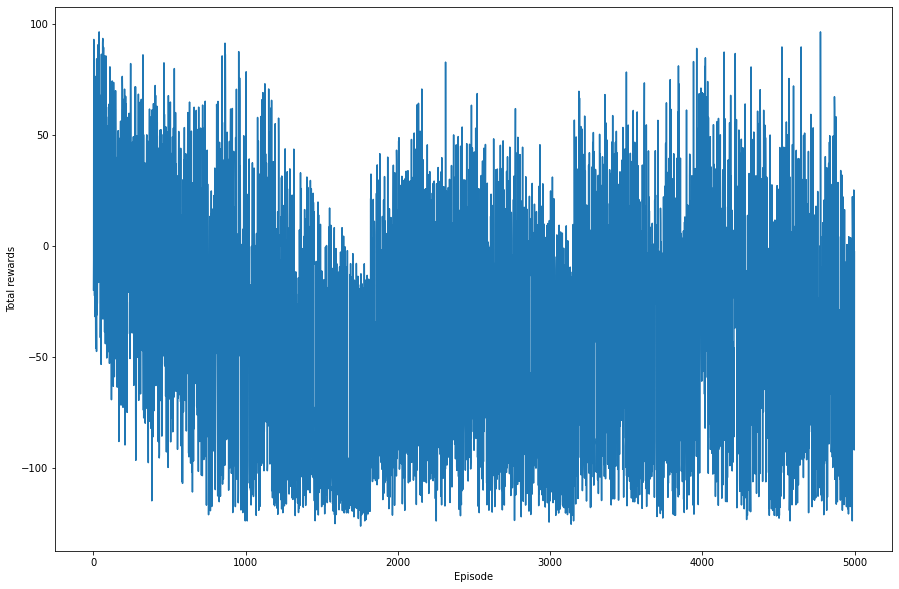

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

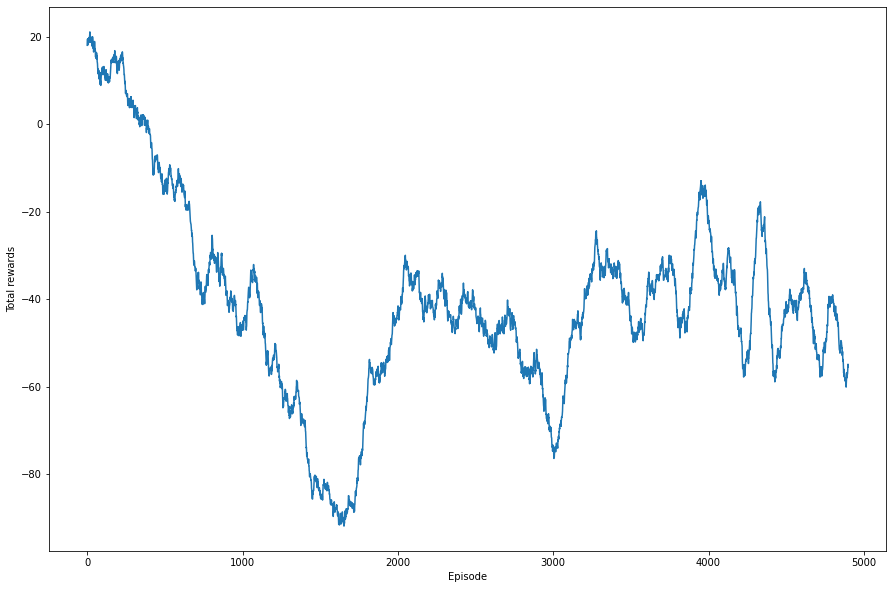

In [12]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

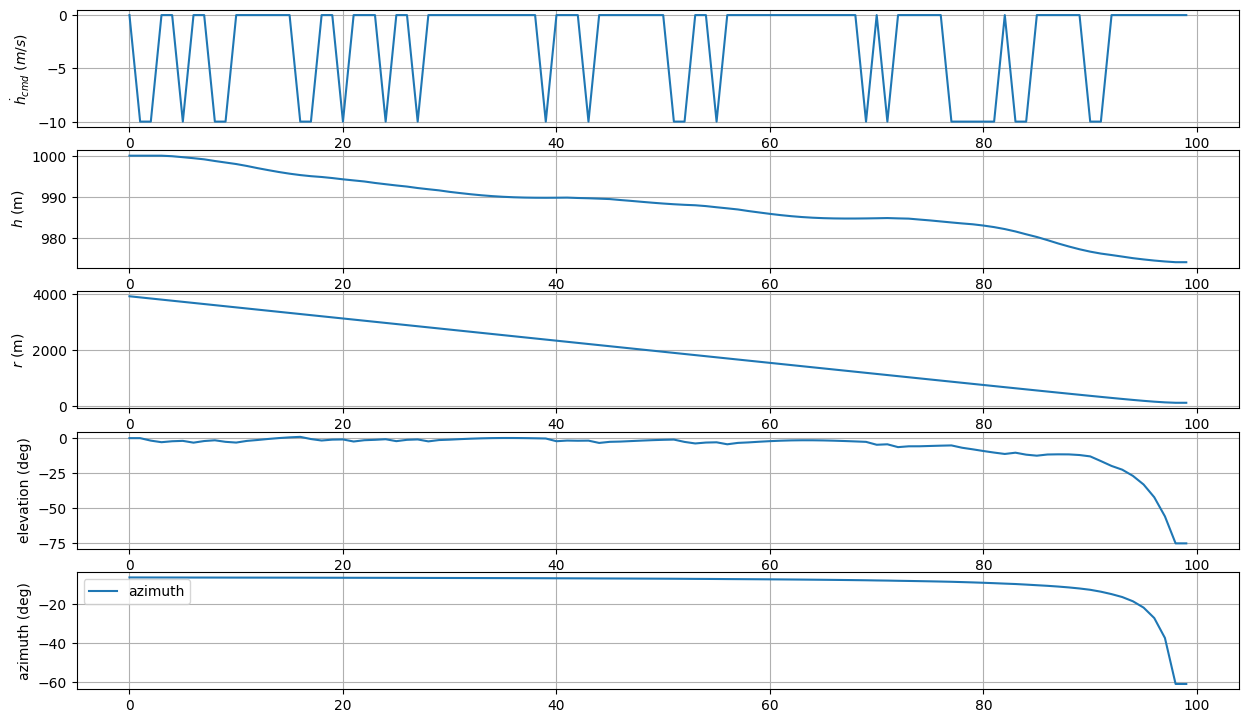

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[39]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

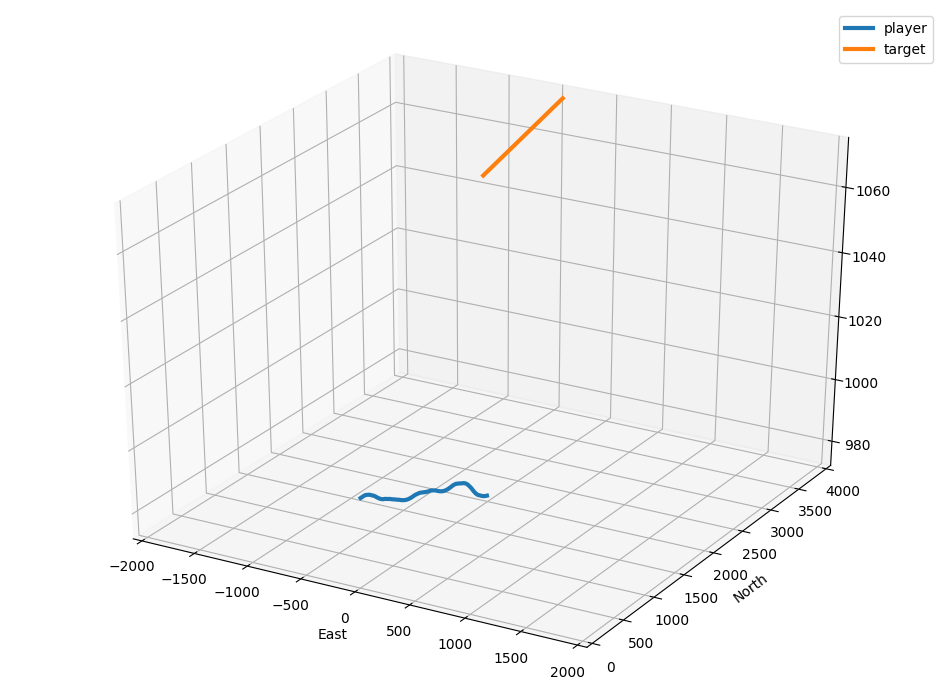

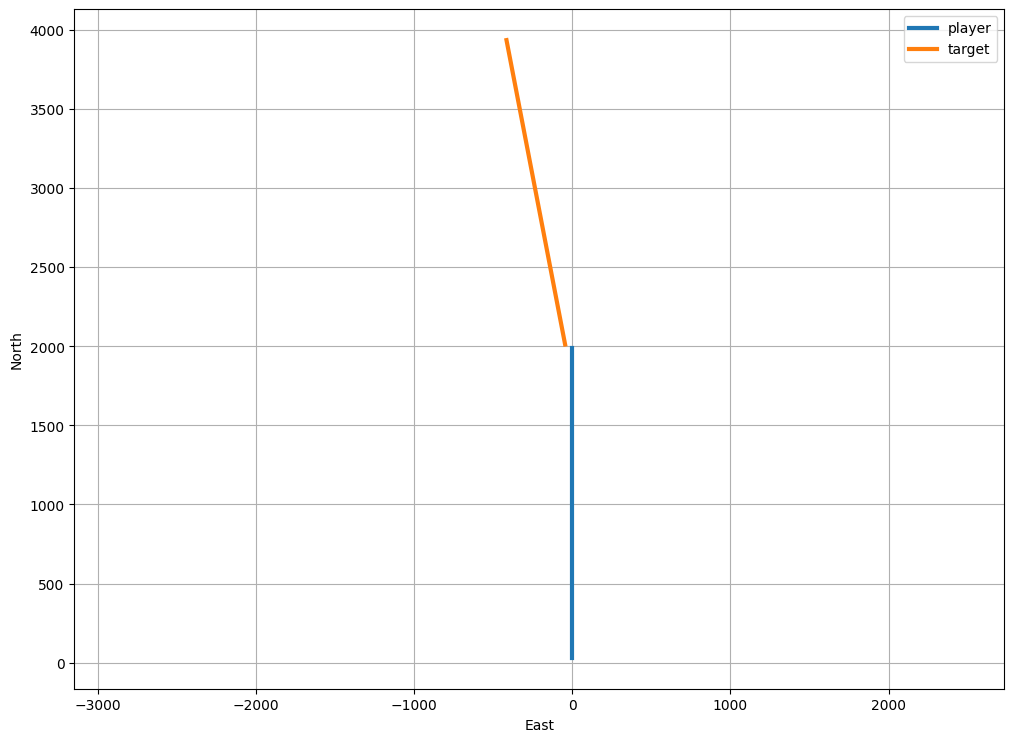

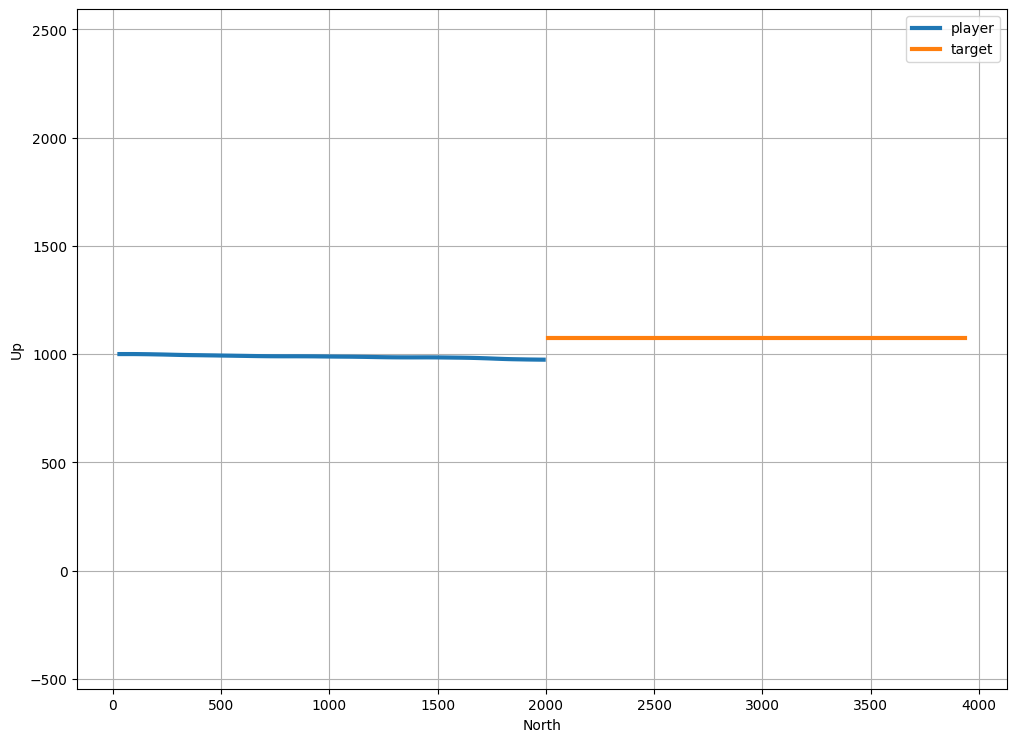

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [15]:
min(plt_res[:,1])

110.8956122313622